# Demo notebook for loading/filtering STORM datasets

Version 1.1, 05 Jan 2023

https://www.nature.com/articles/s41597-020-0381-2

https://doi.org/10.4121/uuid:82c1dc0d-5485-43d8-901a-ce7f26cda35d

https://data.4tu.nl/articles/STORM_IBTrACS_present_climate_synthetic_tropical_cyclone_tracks/12706085?file=24876980

The 10,000 year TC STORM dataset, based on the present climate, is publicly accessible and can be found on the 4TU.Centre for Research Data repository (https://doi.org/10.4121/uuid:82c1dc0d-5485-43d8-901a-ce7f26cda35d). The dataset is split in separate files per basin, with each .txt-file containing 1,000 years of simulations (i.e. 10 files per basin). Each .txt-file consists of a series of arrays, with each array being a single time step (3-hourly) for a synthetic TC. The colmns of the arrays are given in this table: 

<img src="static/Table2.png" width=600 height=600 />


Bloemendaal, Nadia; Haigh, I.D. (Ivan); de Moel, H. (Hans); Muis, S; Haarsma, R.J. (Reindert) et. al. (2022): STORM IBTrACS present climate synthetic tropical cyclone tracks. Version 4. 4TU.ResearchData. dataset. https://doi.org/10.4121/12706085.v4

Bloemendaal, Nadia; de Moel, H. (Hans); Martinez, Andrew B.; Muis, S. (Sanne); Haigh, I.D. (Ivan) et. al. (2023): STORM Climate Change synthetic tropical cyclone tracks. Version 2. 4TU.ResearchData. dataset. https://doi.org/10.4121/14237678.v2


In [1]:
import os
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

# import seaborn as sns
# sns.set()

import cartopy.crs as ccrs

import cheer_utils

/var/folders/9p/47_kp6ns54g0ls7g_zpzn0lh0000gq/T/ipykernel_89177/3908063879.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# define some plotting vars

makeplots=True
writeoutputfiles=False


# define dicts for filtering circles for case study areas:
a=np.arange(0,370,10)*np.pi/180
rad=3
lo=-76.5
la=34.75
# test track screening circle
# rad= .3
# lo=-77.75
# la=35
nc_circ={'lo': lo,
         'la': la, 
         'rad': rad,
         'cirx': rad*np.cos(a)+lo,
         'ciry': rad*np.sin(a)+la}

rad=3
lo=-94
la=29.5
tx_circ={'lo': lo,
         'la':  la,
         'rad': rad,
         'cirx': rad*np.cos(a)+lo,
         'ciry': rad*np.sin(a)+la}

In [3]:
basin='NA'
ensnum=0

climate='current' 
model='present'  

#climate='future'
#model='HADGEM'   #  'CMCC' 'CNRM' 'ECEARTH' 'HADGEM'
#mod_dict= {'CMCC': 'CMCC-CM2-VHR4',   'CNRM':'CNRM-CM6-1-HR',  'ECEARTH':'EC-Earth3P-HR', 'HADGEM':'HadGEM3-GC31-HM'}

baseurl='https://tdsres.apps.renci.org/thredds/fileServer/datalayers/STORM_Bloemendaal_data'
if climate == 'current':
    url=f'{baseurl}/present/STORM_DATA_IBTRACS_{basin}_1000_YEARS_{ensnum}.txt'
else:
    url=f'{baseurl}/future/{model}/STORM_DATA_{mod_dict[model]}_{basin}_1000_YEARS_{ensnum}_IBTRACSDELTA.txt'

# #url=f'http://tds3.renci.org:8080/thredds/fileServer/cheer/STORM_Bloemendaal_data/future/HADGEM/STORM_DATA_HadGEM3-GC31-HM_{basin}_1000_YEARS_{ensnum}_IBTRACSDELTA.txt'
# print(url)
# print(' http://tdsres.apps.renci.org/thredds/fileServer/datalayers/STORM_Bloemendaal_data/present/STORM_DATA_IBTRACS_EP_1000_YEARS_0.txt')

# Load the STORM dataset
df=cheer_utils.LoadSTORMFile(url)
idx_all=np.unique(df.index).astype(int)  # update index

# Compute a "distance" to the target areas, used to screen storm population
df['dist2nc']=np.sqrt(np.square(df['Longitude']-nc_circ['lo']) + np.square(df['Latitude']-nc_circ['la']))
df['dist2tx']=np.sqrt(np.square(df['Longitude']-tx_circ['lo']) + np.square(df['Latitude']-tx_circ['la']))
df['HollandB']=cheer_utils.HbFromRmwLat(df['RMW'],df['Latitude'])

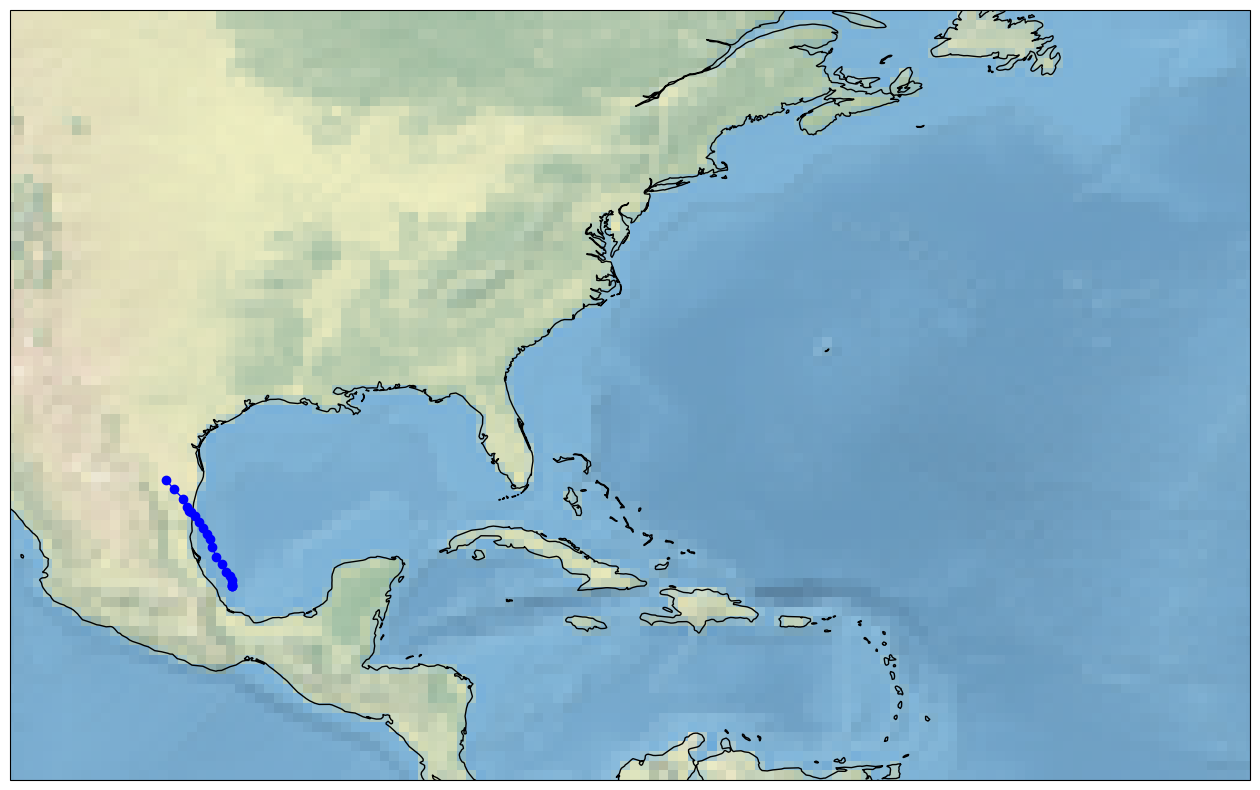

In [4]:
# cartopy test
fig = plt.figure(figsize=(16, 10))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()

x=df.loc[df.index==4143].Longitude
y=df.loc[df.index==4143].Latitude

ax.plot(x, y,
         color='blue', linewidth=1, marker='o',
         #transform=ccrs.Geodetic(),
         )
ax.axis('equal')
ax.set_ylim([10, 50])
ax.set_xlim([-100, -50])
ax.grid(True)

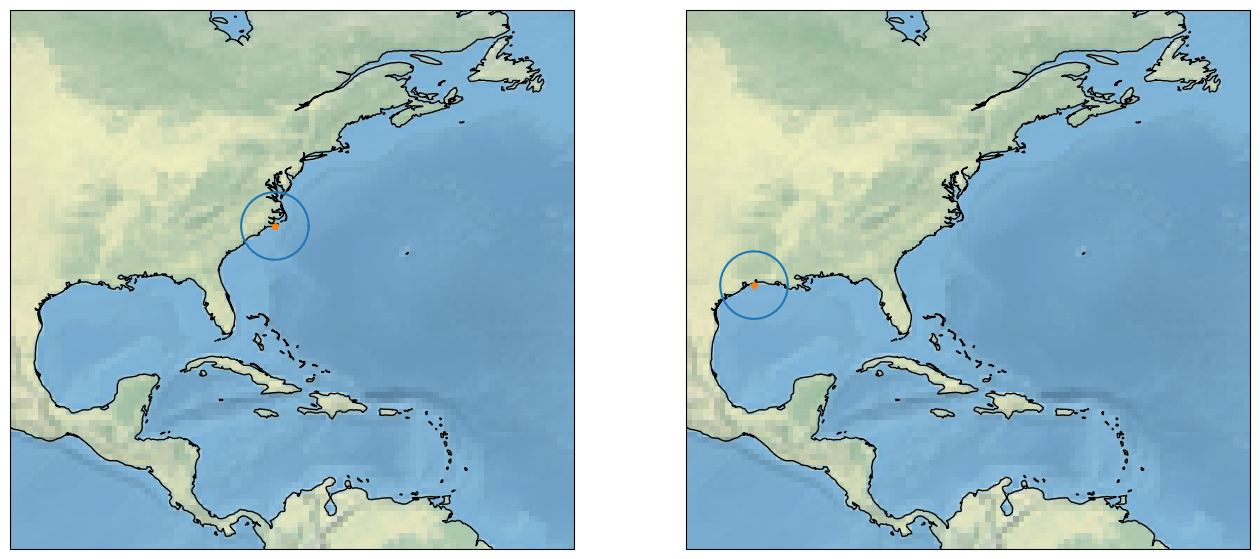

In [5]:
# plot the screening circles
if makeplots:

    fig, ax = plt.subplots(nrows=1,ncols=2,
                           subplot_kw={'projection': ccrs.PlateCarree()},
                           figsize=(16,7))
    ax=ax.flatten()
    
    ax[0].stock_img()
    ax[0].coastlines()
    ax[1].stock_img()
    ax[1].coastlines()
    
    ax[0].plot(nc_circ['cirx'],nc_circ['ciry'],transform=ccrs.PlateCarree())
    ax[1].plot(tx_circ['cirx'],tx_circ['ciry'],transform=ccrs.PlateCarree())

    ax[0].plot(nc_circ['lo'],nc_circ['la'],marker='*',transform=ccrs.PlateCarree())
    ax[1].plot(tx_circ['lo'],tx_circ['la'],marker='*',transform=ccrs.PlateCarree())

    for i in range(0,2):
        ax[i].axis('equal')
        ax[i].set_ylim([10, 50])
        ax[i].set_xlim([-100, -50])
        ax[i].grid(True)
    

In [6]:
# Find the storm index numbers (anssn) that pass thru the screening circles
# This gets the parts of tracks that enter the circles.  The complete track will be extracted below
df_nc=df.loc[(df['dist2nc'] <= nc_circ['rad'])]# & (df['Min_pres'] <= 980)]
df_tx=df.loc[(df['dist2tx'] <= tx_circ['rad'])]# & (df['Min_pres'] <= 980)]
# df_nc=df.loc[(df['dist2nc'] <=nc_circ['rad']) & (df['Category'] > 2)]
# df_tx=df.loc[(df['dist2tx'] <=tx_circ['rad']) & (df['Category'] > 2)]
idx_nc=np.unique(df_nc.index).astype(int)
idx_tx=np.unique(df_tx.index).astype(int)
print(f'Initial number of NC events = {len(idx_nc)}')
print(f'Initial number of TX events = {len(idx_tx)}')

Initial number of NC events = 588
Initial number of TX events = 493


In [7]:
# Screen out storms shorter than MinDays

MinDays=4
temp_list=list()
for idx in idx_nc: 
    df_temp=df.loc[df.index==idx].copy()    
    d=df_temp.iloc[:,2].values[-1]
    if d > MinDays: 
        temp_list.append(df_temp)
df_nc=pd.concat(temp_list)
idx_nc=np.unique(df_nc.index).astype(int)  # update index
          
temp_list=list()
for idx in idx_tx:
    df_temp=df.loc[df.index==idx].copy()
    d=df_temp.iloc[:,2].values[-1]
    if d > MinDays: 
        temp_list.append(df_temp)    
df_tx=pd.concat(temp_list)
idx_tx=np.unique(df_tx.index).astype(int)

print(f'Number of NC events = {len(idx_nc)}')
print(f'Number of TX events = {len(idx_tx)}')

Number of NC events = 261
Number of TX events = 73


Number of NC events = 240
Number of TX events = 69


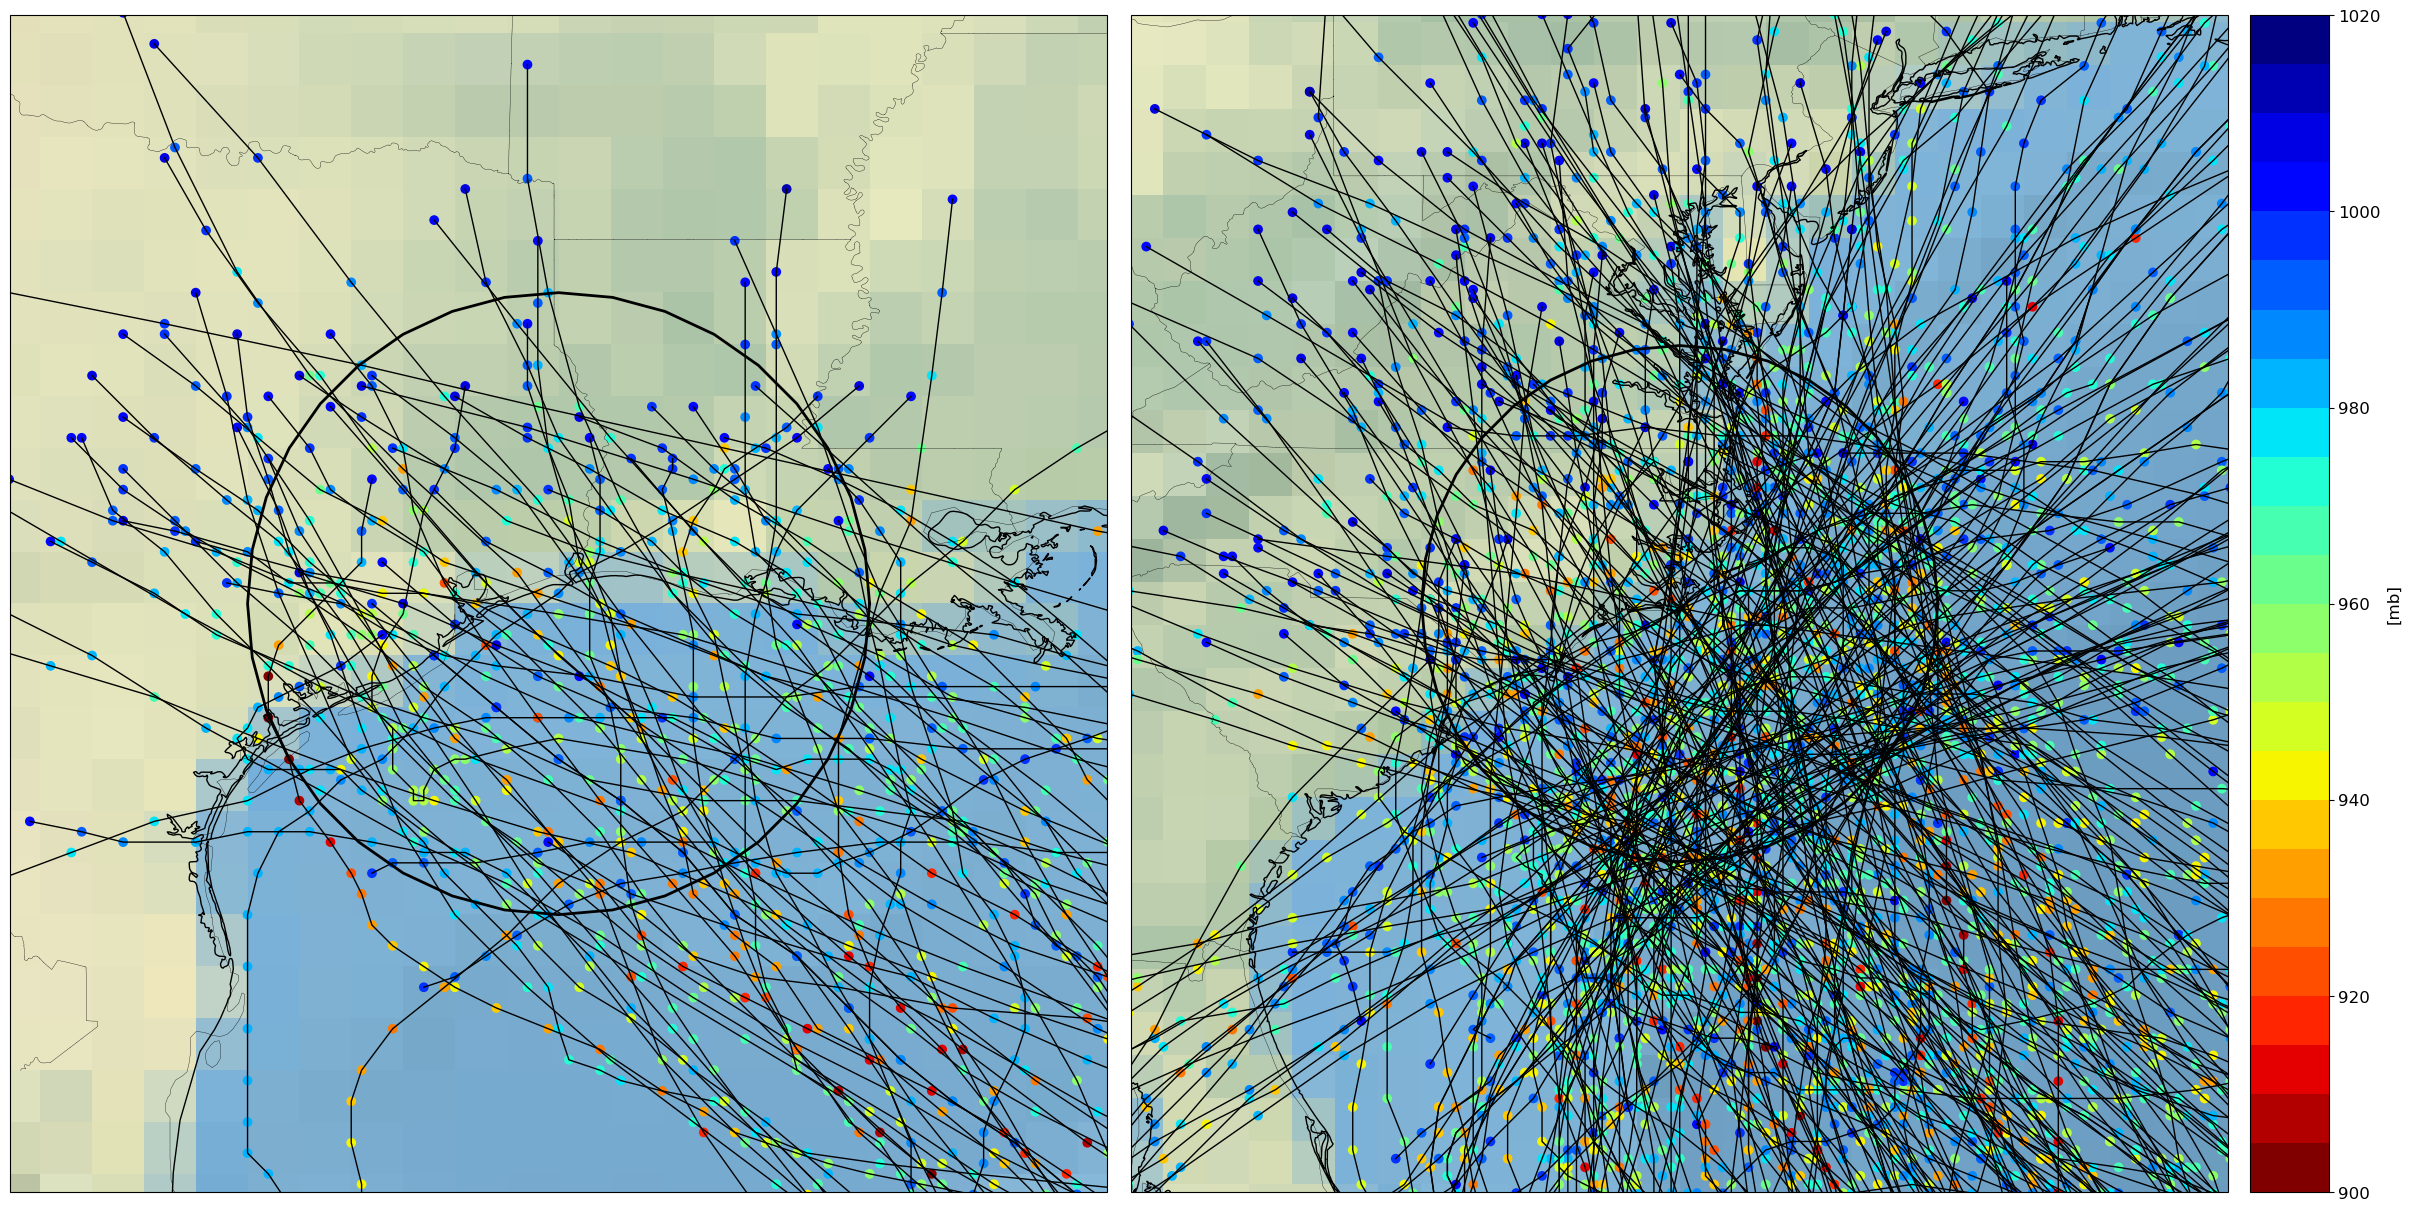

In [8]:
# Screen out parts of storm tracks significantly far from the study areas
# and eliminate storms that start within the screening circle. 

# NC

MaxLon_At_Start_Of_Track_NC=-60
MaxLat_At_End_Of_Track_NC=45
temp_list=list()

for i,idx in enumerate(idx_nc): 
    
    df_temp=df_nc.loc[df_nc.index==idx].copy()    
    
    while df_temp['Longitude'].iloc[0] > MaxLon_At_Start_Of_Track_NC:
        df_temp = df_temp.iloc[1: , :]
    while df_temp['Longitude'].iloc[-1] > MaxLon_At_Start_Of_Track_NC:
        df_temp = df_temp.iloc[:-2 , :]
    while df_temp['Latitude'].iloc[-1] > MaxLat_At_End_Of_Track_NC:
        df_temp = df_temp.iloc[:-2 , :]
    if df_temp.dist2nc.iloc[0] < nc_circ['rad']:
        df_temp = pd.DataFrame()
        
    temp_list.append(df_temp)
    
df_nc=pd.concat(temp_list)
idx_nc=np.unique(df_nc.index).astype(int)  # update index

# TX 

MinLon_At_Start_Of_Track_TX=-81
temp_list=list()

for i,idx in enumerate(idx_tx): 

    df_temp=df_tx.loc[df_tx.index==idx].copy()    
    
    while df_temp['Longitude'].iloc[0] > MinLon_At_Start_Of_Track_TX:
        df_temp = df_temp.iloc[1: , :]
    while df_temp['Longitude'].iloc[-1] > MinLon_At_Start_Of_Track_TX:
        df_temp = df_temp.iloc[:-2 , :]
    if df_temp.dist2tx.iloc[0] < tx_circ['rad']:
        df_temp = pd.DataFrame()
        
    temp_list.append(df_temp)
    
df_tx=pd.concat(temp_list)
idx_tx=np.unique(df_tx.index).astype(int)

print(f'Number of NC events = {len(idx_nc)}')
print(f'Number of TX events = {len(idx_tx)}')

# make plot of result
if makeplots:
    dlo, dla = 5, 5
    extnc=[nc_circ['lo']-dlo, nc_circ['lo']+dlo, nc_circ['la']-dla, nc_circ['la']+dla]
    exttx=[tx_circ['lo']-dlo, tx_circ['lo']+dlo, tx_circ['la']-dla, tx_circ['la']+dla]
    cheer_utils.fullTrackPlot(df_nc,extnc,nc_circ,df_tx,exttx,tx_circ,fname=f'STORM_{basin}_{ensnum}_NC_TX_{model}_2.png')

In [9]:
if writeoutputfiles: 
    # Flush tracks to csv files
    # Loop over abssn in subset and export complete track for each

    if not os.path.exists('CHEER_Tracks'):
        os.mkdir('CHEER_Tracks')
    if not os.path.exists(f'CHEER_Tracks/{model}'):
        os.mkdir(f'CHEER_Tracks/{model}')

    for idx in idx_nc: # [0:10]:
        fname=f'CHEER_Tracks/{model}/NC_{model}_{ensnum}_{idx:05d}.csv'
        df_temp=df_nc.loc[df_nc.index==idx]
        df_temp.to_csv(fname,float_format='%.3f')

    # for idx in idx_tx: # [0:10]:
    #     fname=f'CHEER_Tracks/TX_Present_{ensnum}_{idx:05d}.csv'
    #     df_temp=df_tx.loc[df_tx.index==idx]
    #     df_temp.to_csv(fname,float_format='%.3f')

    # also save as pkl files for subsequent loading/analysis
    df_nc.to_pickle(f'CHEER_Tracks/{model}/NC_{model}_{ensnum}.pkl')
    # df_tx.to_pickle(f'TX_Present_{ensnum}.pkl')

In [ ]:
if writeoutputfiles: 
    # output for ADCIRC NWS67
    #     time      lon      lat      dp       du       dv     RMW    B
    #    [days]    [deg]    [deg]    [Pa]     [m/s]    [m/s]  [km]    []
    dt=3*3600

    #test_nc_indx=[1454, 7032, 7981]

    dropvars=['Basin_ID','TC_number','Landfall','Dist2land','dist2nc','dist2tx','Category','Month','Year','Day','Hour','Time_step']
    keepvars=['Longitude', 'Latitude', 'Dp','du','dv','RMW','HollandB'] # ,'abssn']

    for idx in idx_nc: 

        df_temp=df_nc.loc[df_nc.index==idx].copy()

        # display(df_temp.head(2))
        # display(df_temp.tail(2))

        temp=df_temp.index

        df_temp['Dp']=101300-df_temp['Min_pres']*100

        du=((df_temp['Longitude']*1.1119e+05).diff())/dt
        du.iloc[0]=du.iloc[1]
        df_temp['du']=du

        dv=((df_temp['Latitude']*1.1119e+05).diff())/dt
        dv.iloc[0]=dv.iloc[1]
        df_temp['dv']=dv

        df_temp['time']=df_temp.Year+df_temp.Month/12+df_temp.Day/365+df_temp.Hour/8760
        df_temp.set_index('time',inplace=True)
        df_temp['abssn']=temp

        df_temp = df_temp.drop(dropvars,axis=1)
        df_temp = df_temp[keepvars]

        #df_temp_stalled=storm_stall(df_temp)

        #fname=f'CHEER_Tracks/{model}/NC_{model}_{ensnum}_{idx:05d}_ext.22'
        #df_temp_stalled.to_csv(fname,float_format='%.6f',header=False)

        fname=f'CHEER_Tracks/{model}/NC_{model}_{ensnum}_{idx:05d}.22'
        df_temp.to_csv(fname,float_format='%.6f',header=False)


In [ ]:
# plot a few tracks
if makeplots:
    idx=idx_nc[np.random.randint(len(idx_nc), size=3)] # [1454, 7032, 7981]
    temp_list=[]
    for i,b in enumerate(idx): 
        df_temp=df_nc.loc[df_nc.index==b]#.copy()    
        temp_list.append(df_temp) 
    df_sub=pd.concat(temp_list)

    fig2, ax2 = plt.subplots(nrows=1, ncols=1, 
                             figsize=(10,3), 
                             constrained_layout=True) #, sharey=True)

    extent=[-85, -56, 15, 40]
    fig,ax=cheer_utils.TrackPlot(df_sub,extent=extent,fname=f'STORM_{basin}_NC_{climate}_{ensnum}_exampleTrack.png')

    for i,b in enumerate(idx): 
        x=df_sub.loc[df_sub.index==b].Longitude
        y=df_sub.loc[df_sub.index==b].Latitude
        p=df_sub.loc[df_sub.index==b].Min_pres
        t=df_sub.loc[df_sub.index==b].Time_step
        sn=df_sub.loc[df_sub.index==b].index.values.astype('str')
    #    for x2, y2 in zip(x[::6], y[::6]):
        ax.text(x.iloc[0], y.iloc[0], sn[0], clip_on=True, fontsize=24)

        ax2.plot(t-t.iloc[0],p)

    ax2.set_ylabel('Pressure [mb]')
    ax2.set_xlabel('Track Hours')

    ax.set_xlim([-90, -58])
    ax.set_ylim([20, 40])

# Figure 4: Synthetic hurricanes from the STORM dataset. 

In [ ]:
# Interesting plot of all tracks and case study tracks
if makeplots: 
    # basin-scale
    extent = [ -110, 0, 5, 60] 
    #central_lon = np.mean(extent[:2])
    #central_lat = np.mean(extent[2:])

    width=12
    fac=(extent[1]-extent[0])/(extent[3]-extent[2])

    fig, ax = plt.subplots(nrows=1, ncols=1, 
                           figsize=(width, width/fac), 
                           constrained_layout=True)

    for i,idx in enumerate(idx_all): 
        x=df.loc[df.index==idx].Longitude
        y=df.loc[df.index==idx].Latitude
        c=df.loc[df.index==idx].Min_pres
        ax.plot(x, y, linewidth=.1, color='k')
        #cm=ax[0].scatter(x=x, y=y, c=c, cmap=cmap, norm=norm, s=12)

    for i,idx in enumerate(idx_tx): 
        x=df_tx.loc[df_tx.index==idx].Longitude
        y=df_tx.loc[df_tx.index==idx].Latitude
        c=df_tx.loc[df_tx.index==idx].Min_pres
        ax.plot(x, y, linewidth=1,  color='r')

    for k,idx in enumerate(idx_nc): 
        x=df_nc.loc[df_nc.index==idx].Longitude
        y=df_nc.loc[df_nc.index==idx].Latitude
        c=df_nc.loc[df_nc.index==idx].Min_pres
        ax.plot(x, y, linewidth=1, color='b')

    ax.plot(cheer_utils.coastline[:,0],cheer_utils.coastline[:,1],color='k',linewidth=.25)
    ax.plot(cheer_utils.statelines[:,0],cheer_utils.statelines[:,1],color='k',linewidth=.25)

    ax.axis('equal')
    ax.set_xlim(extent[0:2])
    ax.set_ylim(extent[2:4])
    ax.grid(True)

    # cb1 = fig.colorbar(cm, ax=ax, orientation='vertical', shrink=0.65, pad=0.025)
    # cb1.ax.set_ylabel('[mb]', size=16)
    # cb1.ax.tick_params(labelsize='large')

    plt.box(True)

    fig.savefig(f'STORM_{basin}_{climate}_{model}_{ensnum}.png')

In [ ]:
# basic plots
if makeplots:
    fig, ax = plt.subplots(nrows=1, ncols=3, 
                           figsize=(10,5), 
                           constrained_layout=True) #, sharey=True)

    df_sub['Category'].hist(ax=ax[0],bins=np.linspace(-0.5,5.5,7),density=True)
    ax[0].set_title('SS Category')
    df_sub['MaxWindSpd'].hist(ax=ax[1],bins=np.linspace(-5,85,20),density=True)
    ax[1].set_title('MaxWindSpd')
    df_sub['RMW'].hist(ax=ax[2],bins=np.linspace(-5,105,24),density=True)
    ax[2].set_title('RMW');


In [ ]:
# print(df_temp)
cheer_utils.out_to_nws8(df_temp,fname='test.nws8',stormname=f'x{df_temp.index[0]:04n}')
#cheer_utils.out_to_nws8(df_temp,fname='test.nws8')

In [ ]:
if writeoutputfiles: 
    for idx in idx_nc: 
        df_temp=df_nc.loc[df_nc.index==idx]
        fname=f'CHEER_Tracks/{model}/NC_{model}_{ensnum}_{idx:05d}.nws8'
        cheer_utils.out_to_nws8(df_temp,fname=fname,stormname=f'x{idx:04n}')

In [ ]:
# extent=[-80, -60, 20, 40]
# #fig,ax=fullTrackPlot(df_nc,extent,nc_circ,df_tx,extent,tx_circ,fname=None)  # 'STORM_NA_0_NC_TX_PRESENT_1.png')
# fig,ax=TrackPlot(df_nc,extent=extent)
# rad=.3
# lo=-77.75
# la=35
# nc_circ_test={'lo': lo,
#               'la': la, 
#               'rad': rad,
#               'cirx': rad*np.cos(a)+lo,
#               'ciry': rad*np.sin(a)+la}

# ax.plot(nc_circ_test['cirx'],nc_circ_test['ciry'])#,transform=crs)

# for i,idx in enumerate(idx_nc): 
#     x=df.loc[df.index==idx].Longitude
#     y=df.loc[df.index==idx].Latitude
#     sn=df.loc[df.index==idx].index.values.astype('str')
#     for x2, y2 in zip(x[::6], y[::6]):
#         ax.text(x2, y2, sn[0], clip_on=True, fontsize=12)


In [ ]:
# MaxLat_At_End_Of_Track_NC=45
# for i,idx in enumerate(idx_nc): 
#     df_temp=df_nc[df_nc.index==idx]
#     if df_temp.Latitude.iloc[-1]>MaxLat_At_End_Of_Track_NC:
#         print(i,idx,df_temp.Latitude.iloc[-1])
#         break

# df_temp=df_nc.loc[df_nc.index==idx].copy()    
# print(df_temp.Latitude.iloc[-10:])
# while df_temp['Longitude'].iloc[0] > MaxLon_At_Start_Of_Track_NC:
#     df_temp = df_temp.iloc[1: , :]
# while df_temp['Longitude'].iloc[-1] > MaxLon_At_Start_Of_Track_NC:
#     df_temp = df_temp.iloc[:-2 , :]
# while df_temp['Latitude'].iloc[-1] > MaxLat_At_End_Of_Track_NC:
#     df_temp = df_temp.iloc[:-2 , :]
# # if df_temp.dist2nc.iloc[0] < nc_circ['rad']:
# #     df_temp = pd.DataFrame()

# print(df_temp.Latitude.iloc[-10:])